In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

np.random.seed(42)
INPUT_DIR = './data/icebergs'

In [7]:
train = pd.read_json(f'{INPUT_DIR}/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

## Get images from df and save them
For using lama pipelines, manual solution will use the same data

In [9]:
new_imgs = []
for i, row in train.iterrows():
    band_1 = np.reshape(np.array(row.band_1),(75,75))
    band_1 = cv2.normalize(band_1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    band_2 = np.reshape(np.array(row.band_2),(75,75))
    band_2 = cv2.normalize(band_2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    cv2.imwrite(f'./data/icebergs/train_imgs/{row.id}_1.jpg', band_1*255)
    cv2.imwrite(f'./data/icebergs/train_imgs/{row.id}_2.jpg', band_2*255)
    new_imgs.append((row.id, f'./data/icebergs/train_imgs/{row.id}_1.jpg', row.is_iceberg, row.inc_angle))
    new_imgs.append((row.id, f'./data/icebergs/train_imgs/{row.id}_2.jpg', row.is_iceberg, row.inc_angle))
train_data = pd.DataFrame(new_imgs, columns = ['id', 'path', 'label', 'angle'])

In [10]:
train_data.head()

,id,path,label,angle
0,dfd5f913,./data/icebergs/train_imgs/dfd5f913_1.jpg,0,43.9239
1,dfd5f913,./data/icebergs/train_imgs/dfd5f913_2.jpg,0,43.9239
2,e25388fd,./data/icebergs/train_imgs/e25388fd_1.jpg,0,38.1562
3,e25388fd,./data/icebergs/train_imgs/e25388fd_2.jpg,0,38.1562
4,58b2aaa0,./data/icebergs/train_imgs/58b2aaa0_1.jpg,1,45.2859


Let's check if classes are balanced on train

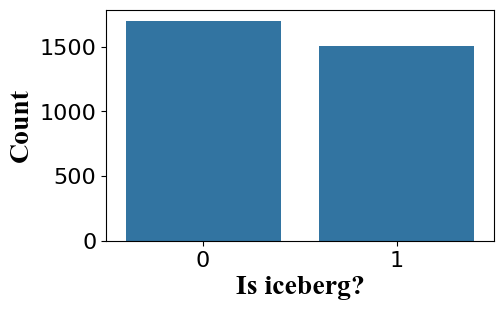

In [11]:
label_count = train_data.groupby('label', as_index=False).count()
label_count.rename(columns={'id': 'count', 'label': 'label_count'}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
font1 = {'family': 'Times New Roman','weight': 'bold','style':'normal','size': 20}
ax.set_xlabel('Is iceberg?',font1)
ax.set_ylabel('Count',font1)
ax = sns.barplot(x=label_count['label_count'], y=label_count['count'])
ax.tick_params(labelsize=16)

plt.show()

Let's plot some examples

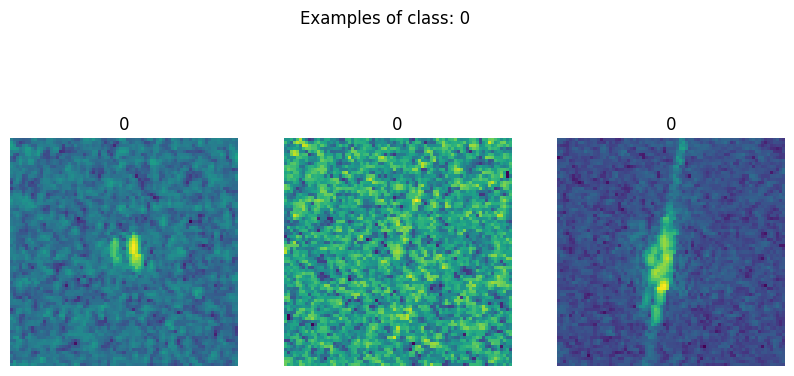

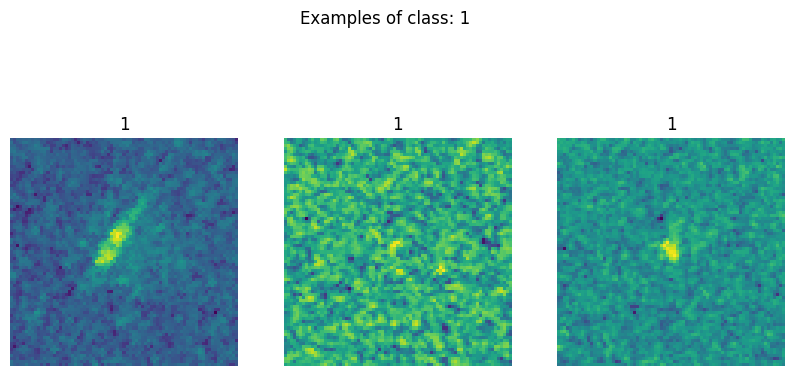

In [12]:
def show_examples(df):
    unique_classes = df['label'].unique()
    for class_name in unique_classes:
        class_df = df[df['label'] == class_name]
        sample_paths = class_df['path'].sample(n=3, random_state=1)  # Выбираем 3 случайных примера из класса
        plt.figure(figsize=(10, 5))
        for i, path in enumerate(sample_paths):
            plt.subplot(1, 3, i + 1)
            img = plt.imread(path)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        plt.suptitle(f'Examples of class: {class_name}')
        plt.show()
show_examples(train_data)

  0%|          | 0/3208 [00:00<?, ?it/s]

100%|██████████| 3208/3208 [00:13<00:00, 230.77it/s]


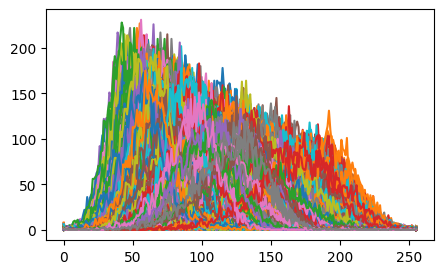

In [13]:
def load_img(path):
    img_bgr = cv2.imread(path)
    img_gs = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return img_gs
if True:
    img_names = train_data.path
    plt.figure(figsize=(5,3),dpi=100)
    pbar = tqdm(img_names, total=len(img_names))
    for img_name in pbar:
        img = load_img(img_name)
        # here use the calchist method in cv2 to show the histogram of photo pixels
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        plt.plot(hist)
    plt.show()
else:
    print('Can not show the details of images')

Nothing suspicious as we see

Let's get some basic statistics from the images

In [14]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

In [15]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

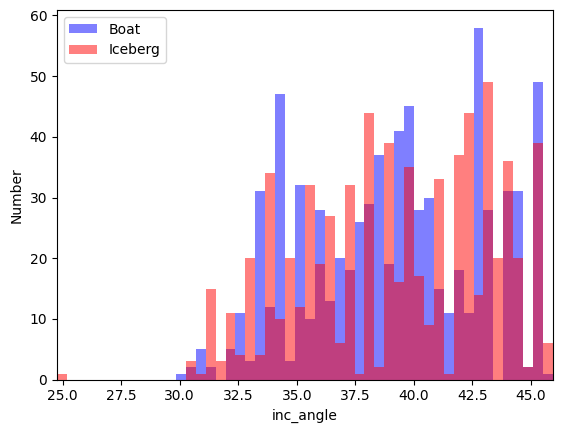

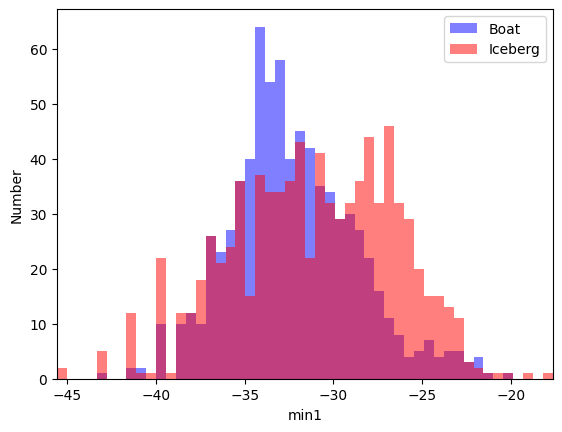

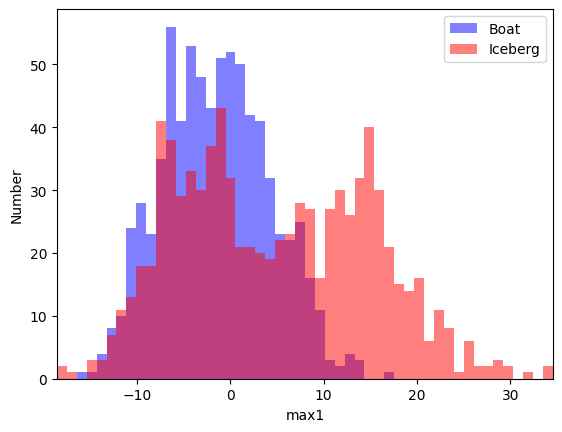

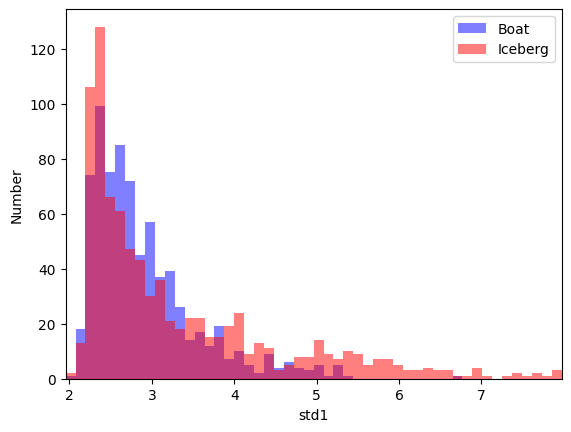

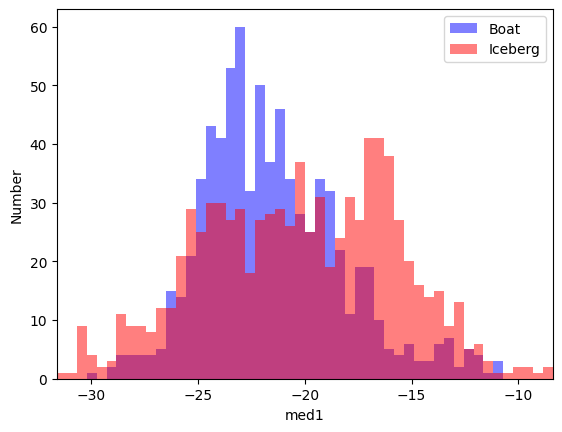

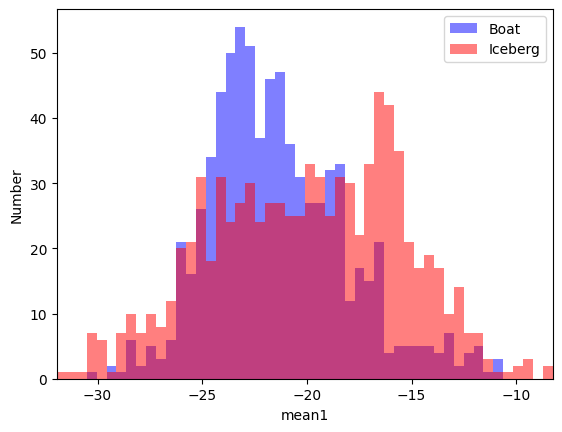

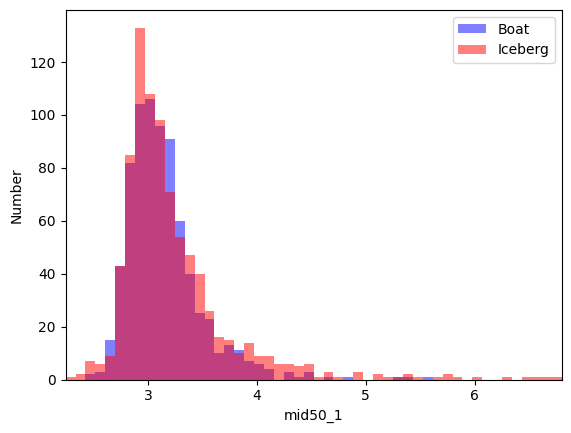

In [16]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

Useful features: mean, median, std, max, min

Now let's see how they correlate

In [17]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

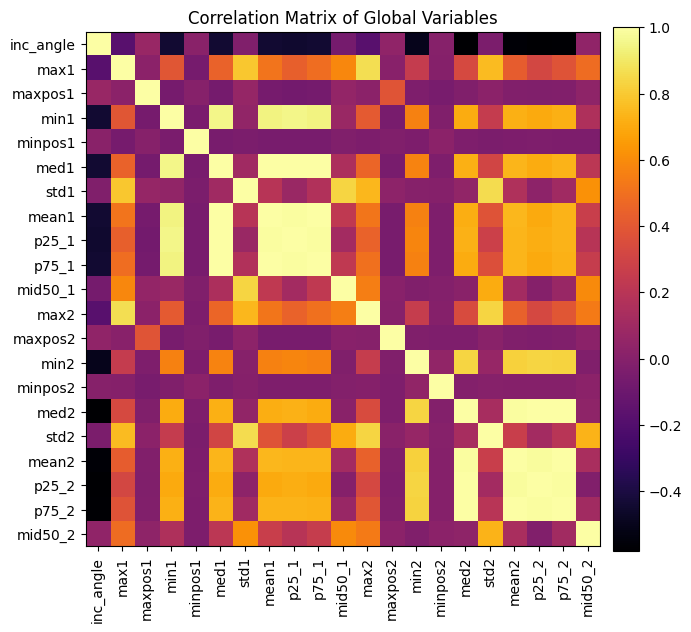

In [18]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(8,8))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

High correlations between mean, median, 25% signal, 75% signal